# Part 3: SQLAlchemy Practice on a Business Database:  

---

By Jean-Yves Tran | jy.tran@[datascience-jy.com](https://datascience-jy.com) | [LinkedIn](https://www.linkedin.com/in/jytran-datascience/)  
IBM Certified Data Analyst 

---

The interactive links in this notebook are not working due to GitHub limitations. View this notebook with the interactive links working [here](https://nbviewer.org/github/jendives2000/Data_ML_Practice_2025/blob/main/1-3-SQL/practice/dvd_rental/PostgreSQL_SQLAlchemy_Biz-Database_dvdrental_2.ipynb#cte-winfunc).

---

This is the 3rd part of my SQLAlchemy series of practice on SQL. 

You can find:
- the [1st notebook](https://github.com/jendives2000/Data_ML_Practice_2025/blob/main/1-3-SQL/practice/dvd_rental/PostGreSQL_SQLALchemy_Business_Database_dvdrental_1.ipynb) 
- and the [2nd one](https://github.com/jendives2000/Data_ML_Practice_2025/blob/0d25e242f449e9689f79cd126921f43e28747278/1-3-SQL/practice/dvd_rental/PostgreSQL_SQLAlchemy_Biz-Database_dvdrental_2.ipynb)
  
Querying time and dates is FUNDAMENTAL to any analysis due to its importance. Time almost always comes up as a variable. So it is vital for any analyst to know how to query time out properly and efficiently.  
So I am  **visiting queries** related to dates and time, especially these functions:
- extract(), to_char, interval, current_date, ::date and age



**POWER OF PYTHON:**  
I show examples of how SQLAlchemy pythonic Core approach can be leveraged to more efficiently produce queries, adding readability too.

**BASIC VISUALIZATIONS:**  
I also translated an output to a pandas dataframe that I then use to visualize the data ([here](#viz_1)) via a scatter plot and 2 box plots. I then give [observations](#obs_1). 

**REFACTORED CODE into FUNCTIONS:**  
For most of the SQL execution I am using a function I declared in the python file ([shared_code.py](https://github.com/jendives2000/Data_ML_Practice_2025/blob/43ed515361fb761e4bb20b73c318a9ddb1266d9e/1-3-SQL/practice/dvd_rental/shared_code.py)), following python best practices. Find it in the same folder of this notebook.  
In that same file I declared functions that I refactored whenever it was possible and necessary. 

### Imports: 

In [51]:
from sqlalchemy import create_engine, cast, alias, select, and_, extract, union, literal, desc, nullsfirst, func, Time, Table, MetaData, Date, text, Integer
from sqlalchemy.types import String
from datetime import date
from dotenv import load_dotenv
import os
from pathlib import Path
from shared_code import execute_stmt, subquery, sql_2_df
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [52]:
# Get the current working directory
current_dir = os.getcwd()


---


### .env file:  

Securing PostGreSQL credentials.

In [53]:
# Get the current working directory
current_dir = os.getcwd()

# Construct the path to the .env file
env_path = Path(current_dir).parents[2] / ".env"
print(f".env file exists: {env_path.exists()}")

# Load environment variables from the .env file
load_dotenv(dotenv_path=env_path)

.env file exists: True


True


---


### Setup of the Connection:

Connecting to the PostGreSQL database dvdrental using SQLAlchemy Core approach. 

In [54]:
# Define the PostgreSQL database URL from environment variables
DATABASE_URL = os.getenv("DATABASE_URL")

# Create the SQLAlchemy engine
engine = create_engine(DATABASE_URL)

# Create a MetaData instance
metadata_obj = MetaData()

<a id="er-diagram"></a>
## ER Diagram of the dvdrental database: 
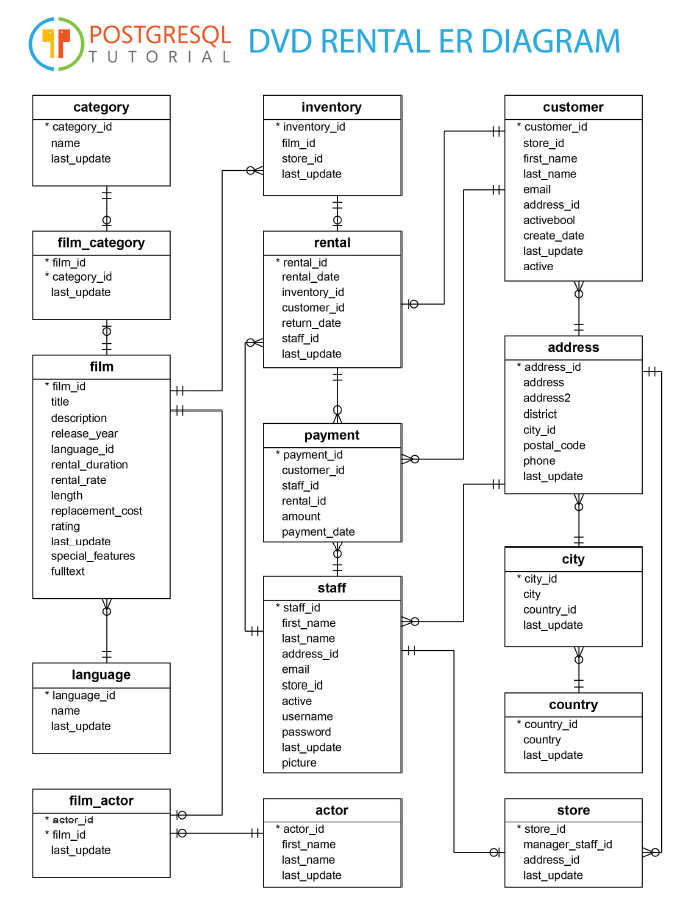


---


#### Tables Reflection:

Now from the database I need to reflect a copy of the tables I need.  It is essentially an in-memory copy of the the database at the state it is now. 

In [55]:
# Reflecting the film table: 
f = Table('film', metadata_obj, autoload_with=engine)

# Reflecting the inventory table: 
i = Table('inventory', metadata_obj, autoload_with=engine)

# Reflecting the payment table: 
p = Table('payment', metadata_obj, autoload_with=engine)

# Reflecting the rental table: 
r = Table('rental', metadata_obj, autoload_with=engine)


---


## EXTRACTing units of time: 

Whenever I need to get specific units of time from a date column I use the extract function.  
In the payment table "p" there is a payment_date column. Let's look at one row:

In [56]:
see_payment_date = select(
    p.c.payment_date
).limit(1)
execute_stmt(see_payment_date, engine)


Total rows selected: 14596
Limit of 1 applied. Rows displayed: 1

Raw SQL query:
SELECT payment.payment_date 
FROM payment 
 LIMIT %(param_1)s

payment_date
------------
2007-02-15  


**NOTE:**  
The output of the payment_date that we see is not the original output, it was formatted this way by the execute_stmt() function. Normally we would also see the hour details, down to the millisecond. 

Just to demonstrate further the utility of the extract() function I am creating:
- 4 columns: year, month, week and day

In [60]:
ppd = p.c.payment_date

four_time_col = select(
    ppd,
    extract('year', p.c.payment_date).label("year"),
    extract('month', p.c.payment_date).label("month"),
    extract('week', p.c.payment_date).label("week"),
    extract('dow', p.c.payment_date).label("dow")
).cte("4_Time_Col")

stmt = select(
    *four_time_col.c
)

execute_stmt(stmt, engine, 5)


Total rows selected: 14596

Raw SQL query:
WITH "4_Time_Col" AS 
(SELECT payment.payment_date AS payment_date, EXTRACT(year FROM payment.payment_date) AS year, EXTRACT(month FROM payment.payment_date) AS month, EXTRACT(week FROM payment.payment_date) AS week, EXTRACT(dow FROM payment.payment_date) AS dow 
FROM payment)
 SELECT "4_Time_Col".payment_date, "4_Time_Col".year, "4_Time_Col".month, "4_Time_Col".week, "4_Time_Col".dow 
FROM "4_Time_Col"

payment_date | year | month | week | dow
----------------------------------------
2007-02-15   | 2007 | 2     | 7    | 4  
2007-02-16   | 2007 | 2     | 7    | 5  
2007-02-16   | 2007 | 2     | 7    | 5  
2007-02-19   | 2007 | 2     | 8    | 1  
2007-02-20   | 2007 | 2     | 8    | 2  


#### Extract in Where clause:  

I now want to:
- filter these dates to only week end days

Remember that saturdays are valued as 6 and sundays as 0.  

In [61]:
fourTimeCol_WE = select(
    *four_time_col.c
    ).where(
        extract(
            "dow", four_time_col.c.payment_date
        ).in_([6, 0])
        ).cte("Only-WE-days")

stmt = select(
    *fourTimeCol_WE.c
)

execute_stmt(stmt, engine, 5)


Total rows selected: 4048

Raw SQL query:
WITH "4_Time_Col" AS 
(SELECT payment.payment_date AS payment_date, EXTRACT(year FROM payment.payment_date) AS year, EXTRACT(month FROM payment.payment_date) AS month, EXTRACT(week FROM payment.payment_date) AS week, EXTRACT(dow FROM payment.payment_date) AS dow 
FROM payment), 
"Only-WE-days" AS 
(SELECT "4_Time_Col".payment_date AS payment_date, "4_Time_Col".year AS year, "4_Time_Col".month AS month, "4_Time_Col".week AS week, "4_Time_Col".dow AS dow 
FROM "4_Time_Col" 
WHERE EXTRACT(dow FROM "4_Time_Col".payment_date) IN (__[POSTCOMPILE_param_1]))
 SELECT "Only-WE-days".payment_date, "Only-WE-days".year, "Only-WE-days".month, "Only-WE-days".week, "Only-WE-days".dow 
FROM "Only-WE-days"

payment_date | year | month | week | dow
----------------------------------------
2007-02-17   | 2007 | 2     | 7    | 6  
2007-02-17   | 2007 | 2     | 7    | 6  
2007-02-17   | 2007 | 2     | 7    | 6  
2007-02-18   | 2007 | 2     | 7    | 0  
2007-02-17  

#### Reformatting Dates:  

I was requested to change the date format to something unambiguous: 
- month shown by their name and not number (January, February etc)
- days of the week shown by their name too (Monday, Tuesday etc)

For that I am using the to_char() function in the CTE I already defined [`four_time_col`](#extract-in-where-clause):

In [62]:
four_time_col = select(
    func.to_char(cast(p.c.payment_date, Date), 'YYYY/Month/DD').label("formatted_date"),
    extract('year', p.c.payment_date).label("year"),
    extract('month', p.c.payment_date).label("month"),
    extract('week', p.c.payment_date).label("week"),
    extract('dow', p.c.payment_date).label("dow")
).cte("payment_cte")

stmt = select(
    *four_time_col.c
)

execute_stmt(stmt, engine)


Total rows selected: 14596

Raw SQL query:
WITH payment_cte AS 
(SELECT to_char(CAST(payment.payment_date AS DATE), %(to_char_1)s) AS formatted_date, EXTRACT(year FROM payment.payment_date) AS year, EXTRACT(month FROM payment.payment_date) AS month, EXTRACT(week FROM payment.payment_date) AS week, EXTRACT(dow FROM payment.payment_date) AS dow 
FROM payment)
 SELECT payment_cte.formatted_date, payment_cte.year, payment_cte.month, payment_cte.week, payment_cte.dow 
FROM payment_cte

formatted_date    | year | month | week | dow
---------------------------------------------
2007/February /15 | 2007 | 2     | 7    | 4  
2007/February /16 | 2007 | 2     | 7    | 5  
2007/February /16 | 2007 | 2     | 7    | 5  
2007/February /19 | 2007 | 2     | 8    | 1  
2007/February /20 | 2007 | 2     | 8    | 2  
2007/February /21 | 2007 | 2     | 8    | 3  
2007/February /17 | 2007 | 2     | 7    | 6  
2007/February /20 | 2007 | 2     | 8    | 2  
2007/February /20 | 2007 | 2     | 8    | 2  
2007/Fe

In [ ]:

# Assume `payment` is a SQLAlchemy Table object for the payment table

# --- Begin CTE: Compute and label all the individual columns ---
# This CTE corresponds to the raw SQL lines:
#   SELECT
#       p.payment_date::date,
#       current_date,
#       to_char(p.payment_date::date, 'YYYY/Month/DD'),
#       EXTRACT(YEAR FROM p.payment_date),
#       EXTRACT(MONTH FROM p.payment_date),
#       EXTRACT(WEEK FROM p.payment_date),
#       EXTRACT(DOW FROM p.payment_date),
#       age(p.payment_date::date) AS age_of_pdate,
four_time_col = select(
    # Raw SQL: p.payment_date::date
    cast(p.c.payment_date, Date).label("payment_date_date"),
    
    # Raw SQL: current_date
    func.current_date().label("current_date"),
    
    # Raw SQL: to_char(p.payment_date::date, 'YYYY/Month/DD')
    func.to_char(cast(p.c.payment_date, Date), 'YYYY/Month/DD').label("formatted_date"),
    
    # Raw SQL: EXTRACT(YEAR FROM p.payment_date)
    extract('year', p.c.payment_date).label("year"),
    
    # Raw SQL: EXTRACT(MONTH FROM p.payment_date)
    extract('month', p.c.payment_date).label("month"),
    
    # Raw SQL: EXTRACT(WEEK FROM p.payment_date)
    extract('week', p.c.payment_date).label("week"),
    
    # Raw SQL: EXTRACT(DOW FROM p.payment_date)
    extract('dow', p.c.payment_date).label("dow"),
    
    # Raw SQL: age(p.payment_date::date) AS age_of_pdate
    func.age(cast(p.c.payment_date, Date)).label("age_of_pdate")
).cte("payment_cte")
# --- End CTE ---

# --- Outer Query: Group by all computed columns and count the rows ---
# This outer query corresponds to the raw SQL:
#   SELECT [all computed columns], COUNT(*)
#   FROM payment p
#   GROUP BY 1,2,3,4,5,6,7,8
query = select(
    payment_cte.c.payment_date_date,   # corresponds to p.payment_date::date,
    payment_cte.c.current_date,          # corresponds to current_date,
    payment_cte.c.formatted_date,        # corresponds to to_char(p.payment_date::date, 'YYYY/Month/DD'),
    payment_cte.c.year,                  # corresponds to EXTRACT(YEAR FROM p.payment_date),
    payment_cte.c.month,                 # corresponds to EXTRACT(MONTH FROM p.payment_date),
    payment_cte.c.week,                  # corresponds to EXTRACT(WEEK FROM p.payment_date),
    payment_cte.c.dow,                   # corresponds to EXTRACT(DOW FROM p.payment_date),
    payment_cte.c.age_of_pdate,          # corresponds to age(p.payment_date::date) AS age_of_pdate,
    func.count().label("count")          # corresponds to COUNT(*)
).group_by(
    payment_cte.c.payment_date_date,
    payment_cte.c.current_date,
    payment_cte.c.formatted_date,
    payment_cte.c.year,
    payment_cte.c.month,
    payment_cte.c.week,
    payment_cte.c.dow,
    payment_cte.c.age_of_pdate
)

execute_stmt(query, engine, 5)


Total rows selected: 32

Raw SQL query:
WITH payment_cte AS 
(SELECT CAST(payment.payment_date AS DATE) AS payment_date_date, CURRENT_DATE AS "current_date", to_char(CAST(payment.payment_date AS DATE), %(to_char_1)s) AS formatted_date, EXTRACT(year FROM payment.payment_date) AS year, EXTRACT(month FROM payment.payment_date) AS month, EXTRACT(week FROM payment.payment_date) AS week, EXTRACT(dow FROM payment.payment_date) AS dow, age(CAST(payment.payment_date AS DATE)) AS age_of_pdate 
FROM payment)
 SELECT payment_cte.payment_date_date, payment_cte."current_date", payment_cte.formatted_date, payment_cte.year, payment_cte.month, payment_cte.week, payment_cte.dow, payment_cte.age_of_pdate, count(*) AS count 
FROM payment_cte GROUP BY payment_cte.payment_date_date, payment_cte."current_date", payment_cte.formatted_date, payment_cte.year, payment_cte.month, payment_cte.week, payment_cte.dow, payment_cte.age_of_pdate

payment_date_date | current_date | formatted_date    | year | month | wee

**NOTE:**  
If for some reasons we needed to have the full months and days name, I can just change the parameters of the .to_char() to the following: 
- .to_char(  
  ppd,  
  **"YYYY Month Day"**)


### Duration of Time past:  
The age function is very useful to quickly get the duration between two dates, known as an interval. 
Let's assume I need to look at:
- the time that passed until today
- since each payment

Let's modify that same CTE:

In [63]:
four_time_col = select(
    ppd,
    func.to_char(cast(p.c.payment_date, Date), 'YYYY/Month/DD').label("formatted_date"),
    extract('year', p.c.payment_date).label("year"),
    extract('month', p.c.payment_date).label("month"),
    extract('week', p.c.payment_date).label("week"),
    extract('dow', p.c.payment_date).label("dow"),
    func.age(cast(p.c.payment_date, Date)).label("age_of_pdate")
).cte("payment_cte")

stmt = select(
    *four_time_col.c)

execute_stmt(stmt, engine, 5)


Total rows selected: 14596

Raw SQL query:
WITH payment_cte AS 
(SELECT payment.payment_date AS payment_date, to_char(CAST(payment.payment_date AS DATE), %(to_char_1)s) AS formatted_date, EXTRACT(year FROM payment.payment_date) AS year, EXTRACT(month FROM payment.payment_date) AS month, EXTRACT(week FROM payment.payment_date) AS week, EXTRACT(dow FROM payment.payment_date) AS dow, age(CAST(payment.payment_date AS DATE)) AS age_of_pdate 
FROM payment)
 SELECT payment_cte.payment_date, payment_cte.formatted_date, payment_cte.year, payment_cte.month, payment_cte.week, payment_cte.dow, payment_cte.age_of_pdate 
FROM payment_cte

payment_date | formatted_date    | year | month | week | dow | age_of_pdate      
---------------------------------------------------------------------------------
2007-02-15   | 2007/February /15 | 2007 | 2     | 7    | 4   | 6560 days, 0:00:00
2007-02-16   | 2007/February /16 | 2007 | 2     | 7    | 5   | 6559 days, 0:00:00
2007-02-16   | 2007/February /16 | 200

By default we get the interval in days and hours. 
I want to have every units of year, months, days and hours. For that I need to use: 
- .concat()
- in it, four .extract(), one for each unit
- and in each extract, .age() to get the interval until today since ppd

I want a CTE just for that statement.

In [34]:
p2 = p.alias("p2")
p2pd = p2.c.payment_date

interval_2today = (
    select(
        func.concat(    
            func.cast(func.extract("year", func.age(func.current_date(), cast(p2pd, Date))), String), " years, ",
            func.cast(func.extract("month", func.age(func.current_date(), cast(p2pd, Date))), String), " months, ",
            func.cast(func.extract("day", func.age(func.current_date(), cast(p2pd, Date))), String), " days, ",
            func.cast(func.extract("hour", func.age(func.current_date(), cast(p2pd, Date))), String), " hours"
        ).label("interval_to_today"),
        p2pd.label("paym_date")
    )
    ).cte("interval_cte")

four_time_col = (
    select(
        interval_2today.c.interval_to_today,
        func.to_char(
            ppd,
            "YYYY FMMon FMDy"
        ).label("payment_date"),
        extract(
            "year", ppd
        ).label("year"),
        extract(
            "month", ppd
        ).label("Mth"),
        extract(
            "week", ppd
        ).label("Wk"),
        extract(
            "dow", ppd
        ).label("Dow"),
    )
).join(
    interval_2today, 
    interval_2today.c.paym_date == p.c.payment_date    # ✅ JOIN instead of recalculatingselect_from(p).cte("4-time-units-col")
    ).cte("4-time-units-col")

stmt = select(
    *four_time_col.c)

execute_stmt(stmt, engine, 5)


Total rows selected: 47638

Raw SQL query:
WITH interval_cte AS 
(SELECT concat(CAST(EXTRACT(year FROM age(CURRENT_DATE, CAST(p2.payment_date AS DATE))) AS VARCHAR), %(concat_1)s, CAST(EXTRACT(month FROM age(CURRENT_DATE, CAST(p2.payment_date AS DATE))) AS VARCHAR), %(concat_2)s, CAST(EXTRACT(day FROM age(CURRENT_DATE, CAST(p2.payment_date AS DATE))) AS VARCHAR), %(concat_3)s, CAST(EXTRACT(hour FROM age(CURRENT_DATE, CAST(p2.payment_date AS DATE))) AS VARCHAR), %(concat_4)s) AS interval_to_today, p2.payment_date AS paym_date 
FROM payment AS p2), 
"4-time-units-col" AS 
(SELECT interval_cte.interval_to_today AS interval_to_today, to_char(payment.payment_date, %(to_char_1)s) AS payment_date, EXTRACT(year FROM payment.payment_date) AS year, EXTRACT(month FROM payment.payment_date) AS "Mth", EXTRACT(week FROM payment.payment_date) AS "Wk", EXTRACT(dow FROM payment.payment_date) AS "Dow" 
FROM payment JOIN interval_cte ON interval_cte.paym_date = payment.payment_date)
 SELECT "4-time-unit

### Specific Interval: 

Ok now I want to additionally have:
- the date corresponding to 1 week   
- before each payment date.   

For that I use the text() construct with inside the specific interval I want, so 1 week.  
Let's add to the code we worked on so far:

In [67]:
four_time_col = select(
    ppd,
    (ppd - text("INTERVAL '7 days'")).label("oneWk_bef_interval"),
    func.to_char(cast(p.c.payment_date, Date), 'YYYY/Month/DD').label("formatted_date"),
    func.age(cast(p.c.payment_date, Date)).label("age_of_pdate"),
    extract('year', p.c.payment_date).label("year"),
    extract('month', p.c.payment_date).label("month"),
    extract('week', p.c.payment_date).label("week"),
    extract('dow', p.c.payment_date).label("dow"),
).cte("payment_cte")

stmt = select(
    *four_time_col.c)

execute_stmt(stmt, engine, 5)


Total rows selected: 14596

Raw SQL query:
WITH payment_cte AS 
(SELECT payment.payment_date AS payment_date, payment.payment_date - INTERVAL '7 days' AS "oneWk_bef_interval", to_char(CAST(payment.payment_date AS DATE), %(to_char_1)s) AS formatted_date, age(CAST(payment.payment_date AS DATE)) AS age_of_pdate, EXTRACT(year FROM payment.payment_date) AS year, EXTRACT(month FROM payment.payment_date) AS month, EXTRACT(week FROM payment.payment_date) AS week, EXTRACT(dow FROM payment.payment_date) AS dow 
FROM payment)
 SELECT payment_cte.payment_date, payment_cte."oneWk_bef_interval", payment_cte.formatted_date, payment_cte.age_of_pdate, payment_cte.year, payment_cte.month, payment_cte.week, payment_cte.dow 
FROM payment_cte

payment_date | oneWk_bef_interval | formatted_date    | age_of_pdate       | year | month | week | dow
------------------------------------------------------------------------------------------------------
2007-02-15   | 2007-02-08         | 2007/February /15 | 6560

#### Total number of payment per payment date: 

Let's see if I can add a simple count() function.  
This is where I need to be clear about what that count function will count. Here I want it to count the total number of payments for each payment date.  
I already have each of all my payment dates in the CTE `four_time_col`. Using the count() function in that CTE will force me to use a group_by. And that group_by will just put each of all of these payment dates into one single group, making the count look at each single one of them.  

#### **Think of Grouping like a bucket:**
- If we group before counting, we only have one bucket per date (always 1), so count sees only one date **even if it is the same one repeating**.  
- If we group after counting, we can count all items inside each bucket (correct count!)

So the correct way to get a count of all payment for EACH distinct payment date is to use the count function in the outer query and then group_by all of the concerned columns. 

In [92]:
four_time_col = select(
    cast(ppd, Date).label("pppd"),
    func.current_date().label("current_date"),
    (ppd - text("INTERVAL '7 days'")).label("oneWk_bef_interval"),
    func.to_char(cast(p.c.payment_date, Date), 'YYYY/Month/DD').label("formatted_date"),
    extract('year', p.c.payment_date).label("year"),
    extract('month', p.c.payment_date).label("month"),
    extract('week', p.c.payment_date).label("week"),
    extract('dow', p.c.payment_date).label("dow"),
    func.age(cast(p.c.payment_date, Date)).label("age_of_pdate"),
).cte("four_time_col")

stmt = select(
    *four_time_col.c,
    func.count().label("count")
).group_by(
    *four_time_col.c
    )

execute_stmt(stmt, engine, 5)


Total rows selected: 14365

Raw SQL query:
WITH four_time_col AS 
(SELECT CAST(payment.payment_date AS DATE) AS pppd, CURRENT_DATE AS "current_date", payment.payment_date - INTERVAL '7 days' AS "oneWk_bef_interval", to_char(CAST(payment.payment_date AS DATE), %(to_char_1)s) AS formatted_date, EXTRACT(year FROM payment.payment_date) AS year, EXTRACT(month FROM payment.payment_date) AS month, EXTRACT(week FROM payment.payment_date) AS week, EXTRACT(dow FROM payment.payment_date) AS dow, age(CAST(payment.payment_date AS DATE)) AS age_of_pdate 
FROM payment)
 SELECT four_time_col.pppd, four_time_col."current_date", four_time_col."oneWk_bef_interval", four_time_col.formatted_date, four_time_col.year, four_time_col.month, four_time_col.week, four_time_col.dow, four_time_col.age_of_pdate, count(*) AS count 
FROM four_time_col GROUP BY four_time_col.pppd, four_time_col."current_date", four_time_col."oneWk_bef_interval", four_time_col.formatted_date, four_time_col.year, four_time_col.month, fo

But I get only 1 count per date. Something is forcing the count on individual dates, as if the group-by happened before the proper group-by in the outer query. 

The culprit is the line where I select the one week before interval:  
- `(ppd - text("INTERVAL '7 days'")).label("oneWk_bef_interval"),`
Internally, this line is bucketing all these 1-week-earlier dates, forcing the count on each single one of them, duplicated dates included. Just like using the count and group_by in the CTE as explained just before. 

So the fix is to move that line down to the outer query, in the select: 

In [94]:
four_time_col = select(
    cast(ppd, Date).label("pppd"),
    func.current_date().label("current_date"),
    #(ppd - text("INTERVAL '7 days'")).label("oneWk_bef_interval"),  # disabling it
    func.to_char(cast(p.c.payment_date, Date), 'YYYY/Month/DD').label("formatted_date"),
    extract('year', p.c.payment_date).label("year"),
    extract('month', p.c.payment_date).label("month"),
    extract('week', p.c.payment_date).label("week"),
    extract('dow', p.c.payment_date).label("dow"),
    func.age(cast(p.c.payment_date, Date)).label("age_of_pdate"),
).cte("four_time_col")

stmt = select(
    *four_time_col.c,
    func.count().label("count"),
    (four_time_col.c.pppd - text("INTERVAL '7 days'")).label("oneWk_bef_interval")  # moved it here
).group_by(
    *four_time_col.c
    )

execute_stmt(stmt, engine, 5)


Total rows selected: 32

Raw SQL query:
WITH four_time_col AS 
(SELECT CAST(payment.payment_date AS DATE) AS pppd, CURRENT_DATE AS "current_date", to_char(CAST(payment.payment_date AS DATE), %(to_char_1)s) AS formatted_date, EXTRACT(year FROM payment.payment_date) AS year, EXTRACT(month FROM payment.payment_date) AS month, EXTRACT(week FROM payment.payment_date) AS week, EXTRACT(dow FROM payment.payment_date) AS dow, age(CAST(payment.payment_date AS DATE)) AS age_of_pdate 
FROM payment)
 SELECT four_time_col.pppd, four_time_col."current_date", four_time_col.formatted_date, four_time_col.year, four_time_col.month, four_time_col.week, four_time_col.dow, four_time_col.age_of_pdate, count(*) AS count, four_time_col.pppd - INTERVAL '7 days' AS "oneWk_bef_interval" 
FROM four_time_col GROUP BY four_time_col.pppd, four_time_col."current_date", four_time_col.formatted_date, four_time_col.year, four_time_col.month, four_time_col.week, four_time_col.dow, four_time_col.age_of_pdate

pppd       |

The code works as intended, I fetched:
- total count pf payments for each distinct payment date
- the 1-week-earlier date for each of these payment dates